In [1]:
# !pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit as masking
from torch_geometric.utils.convert import to_networkx

In [12]:
print(sum(targets))

292


In [3]:
# Load your node dataset CSV data into a Pandas DataFrame
node_df = pd.read_csv("/Users/manan/Desktop/Research/Learning/normalized_user_data.csv")

# Extract the node IDs, features, and target values from the DataFrame
node_ids = node_df['id'].values
features = node_df.iloc[:, 1:11].values  # assuming the features start at column 1 and end at column 10
targets = node_df['label'].values

# Create the node feature matrix as a PyTorch tensor
x = torch.tensor(features, dtype=torch.float)

# Create the target vector as a PyTorch tensor
y = torch.tensor(targets, dtype=torch.long)

# Load your edge index CSV data into a Pandas DataFrame
edge_df = pd.read_csv("/Users/manan/Desktop/Research/Learning/converted_edge.csv")

# Extract the source and target node IDs from the DataFrame
source_nodes = edge_df['source_id'].values
target_nodes = edge_df['target_id'].values

# Create the edge index as a PyTorch tensor
edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

# Create the PyTorch data object
data = Data(x=x, y=y, edge_index=edge_index)

msk = masking(split="train_rest", num_splits = 1, num_val = 0.1, num_test= 0.1)

data = msk(data)

# You can access the data object's properties like this:
print(data.x) # print the node feature matrix
print(data.y) # print the target vector
print(data.edge_index) # print the edge index
print("training samples",torch.sum(data.train_mask).item())
print("validation samples",torch.sum(data.val_mask ).item())
print("test samples",torch.sum(data.test_mask ).item())

tensor([[1.2747e-01, 1.0000e+00, 0.0000e+00,  ..., 3.8311e-04, 4.5719e-03,
         1.2792e-04],
        [4.7800e-01, 1.0000e+00, 0.0000e+00,  ..., 1.9423e-03, 2.6903e-03,
         0.0000e+00],
        [1.0409e-01, 1.0000e+00, 0.0000e+00,  ..., 1.1048e-04, 9.7399e-05,
         0.0000e+00],
        ...,
        [4.6519e-01, 0.0000e+00, 1.0000e+00,  ..., 5.0962e-04, 7.1426e-04,
         3.5224e-05],
        [3.9834e-01, 0.0000e+00, 0.0000e+00,  ..., 2.0848e-04, 0.0000e+00,
         0.0000e+00],
        [5.9318e-01, 1.0000e+00, 0.0000e+00,  ..., 3.1005e-04, 4.9438e-04,
         0.0000e+00]])
tensor([0, 0, 0,  ..., 1, 0, 0])
tensor([[ 788,  403, 1849,  ..., 1387, 1086,  606],
        [ 401,  160,  724,  ..., 1486,  427,   88]])
training samples 1600
validation samples 200
test samples 200


/var/folders/cn/7517r4y97_v4x19x2n2wx9jh0000gn/T/ipykernel_41740/2548915183.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)


In [4]:
node_df = pd.read_csv("/Users/manan/Desktop/Research/Learning/small_user.csv")
sample_data = node_df.head()
sample_data.to_csv("sample_data.csv", index=False)

In [5]:
type(source_nodes)

numpy.ndarray

In [6]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p= .25, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p= .25, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p= .25, training=self.training)

        return x

In [7]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)    

def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)    


In [8]:
def train(data, net, optimizer, epochs):

    best_accuracy=0.0

    train_losses=[]
    train_accuracies=[]

    val_losses=[]
    val_accuracies=[]

    test_losses=[]
    test_accuracies=[]

    for ep in range(epochs):
        optimizer.zero_grad()
        out=net(data)
        loss=masked_loss(predictions=out,
                         labels=data.y,
                         mask=data.train_mask)
        loss.backward()
        optimizer.step()
        train_losses+=[loss.item()]
        train_accuracy=masked_accuracy(predictions=out,
                                       labels=data.y, 
                                       mask=data.train_mask)
        train_accuracies+=[train_accuracy.item()]

        val_loss=masked_loss(predictions=out,
                             labels=data.y, 
                             mask=data.val_mask)
        val_losses+=[val_loss.item()]

        val_accuracy=masked_accuracy(predictions=out,
                                     labels=data.y, 
                                     mask=data.val_mask)
        val_accuracies+=[val_accuracy.item()]

        test_accuracy=masked_accuracy(predictions=out,
                                      labels=data.y, 
                                      mask=data.test_mask)
        test_accuracies+=[test_accuracy.item()]
        if val_accuracy > best_accuracy:
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                      .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy

    confusion_matrix(y_true, y_pred)
    plt.plot(train_losses, label="train loss")  
    plt.plot(val_losses, label="val loss")
    plt.plot(test_losses, label="test loss")  
    plt.legend(loc="upper left")
    plt.show()

    plt.plot(train_accuracies, label="train accuracy") 
    plt.plot(val_accuracies, label="val accuracy ")
    plt.plot(test_accuracies, label="test accuracy") 
    plt.legend(loc="upper left")
    plt.show()

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Epoch 1/250, Train_Loss: 0.7561, Train_Accuracy: 0.1975, Val_Accuracy: 0.2600, Test_Accuracy: 0.1600
Epoch 2/250, Train_Loss: 0.7485, Train_Accuracy: 0.2212, Val_Accuracy: 0.2850, Test_Accuracy: 0.2050
Epoch 4/250, Train_Loss: 0.7334, Train_Accuracy: 0.2500, Val_Accuracy: 0.3000, Test_Accuracy: 0.2150
Epoch 5/250, Train_Loss: 0.7259, Train_Accuracy: 0.2700, Val_Accuracy: 0.3150, Test_Accuracy: 0.2450
Epoch 7/250, Train_Loss: 0.7112, Train_Accuracy: 0.3413, Val_Accuracy: 0.3800, Test_Accuracy: 0.3150
Epoch 8/250, Train_Loss: 0.7039, Train_Accuracy: 0.3806, Val_Accuracy: 0.4150, Test_Accuracy: 0.4000
Epoch 9/250, Train_Loss: 0.6969, Train_Accuracy: 0.4775, Val_Accuracy: 0.4900, Test_Accuracy: 0.4900
Epoch 10/250, Train_Loss: 0.6899, Train_Accuracy: 0.5650, Val_Accuracy: 0.5850, Test_Accuracy: 0.5700
Epoch 11/250, Train_Loss: 0.6830, Train_Accuracy: 0.6431, Val_Accuracy: 0.6100, Test_Accuracy: 0.6500
Epoch 12/250, Train_Loss: 0.6761, Train_Accuracy: 0.6787, Val_Accuracy: 0.6300, Test_Accu

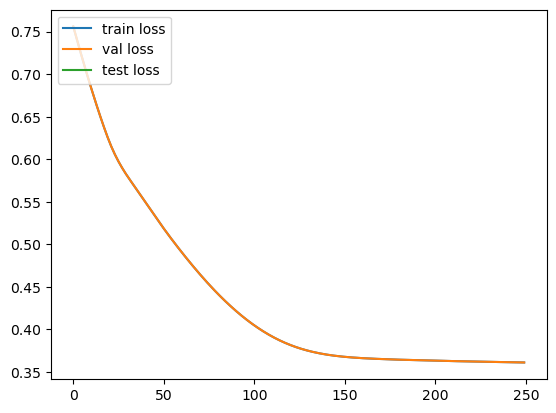

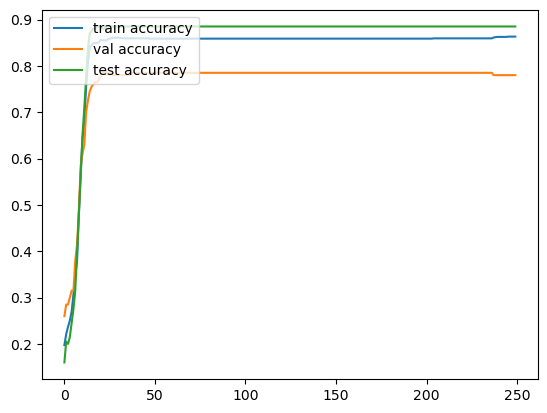

In [10]:
device="cpu"
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion=nn.CrossEntropyLoss()
train(data, model, optimizer, 250)